It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/mehrerm/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/mehrerm/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

In [3]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [4]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

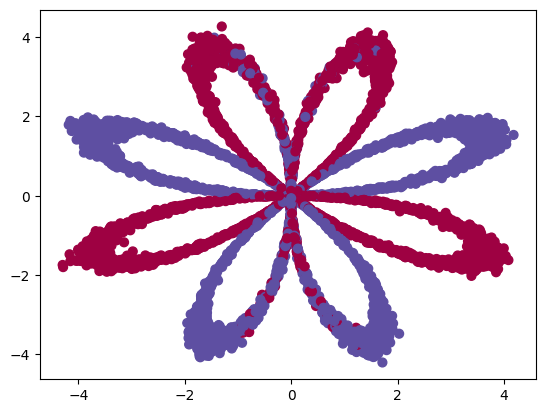

In [5]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [6]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [7]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [8]:
## X first example
X[0,:]

array([-1.46318096,  2.0508727 ])

In [9]:
## Y firsts examples
y[:8]

array([0, 0, 0, 0, 1, 0, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

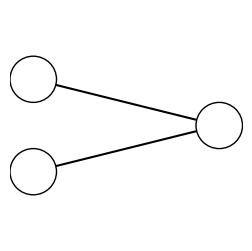

In [10]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [11]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

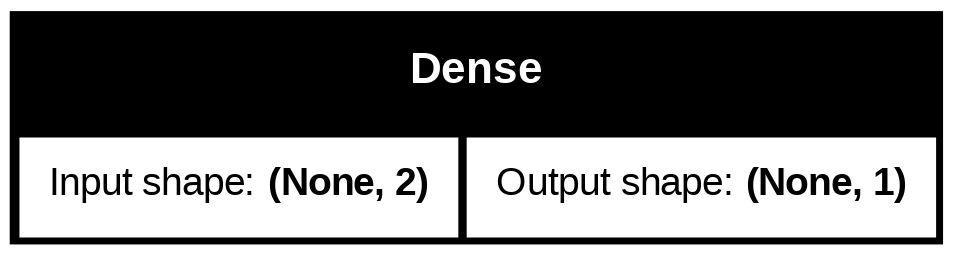

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [15]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6909 - loss: 1.3578 - val_accuracy: 0.6650 - val_loss: 1.3469
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6899 - loss: 1.2818 - val_accuracy: 0.6587 - val_loss: 1.2687
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6885 - loss: 1.2080 - val_accuracy: 0.6562 - val_loss: 1.1933
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6865 - loss: 1.1369 - val_accuracy: 0.6550 - val_loss: 1.1212
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6859 - loss: 1.0690 - val_accuracy: 0.6525 - val_loss: 1.0529
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 1.0050 - val_accuracy: 0.6513 - val_loss: 0.9891
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6819 - loss: 0.9454 - val_accuracy: 0.6513 - val_loss: 0.9305
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6801 - loss: 0.8910 - val_accuracy: 0.

#### Making predictions

In [16]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.7554705739021301
Test Accuracy: 0.6669999957084656


In [17]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(array([[0.48841226],
        [0.79477054],
        [0.84386057]], dtype=float32),
 array([1, 1, 0], dtype=uint8))

1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step


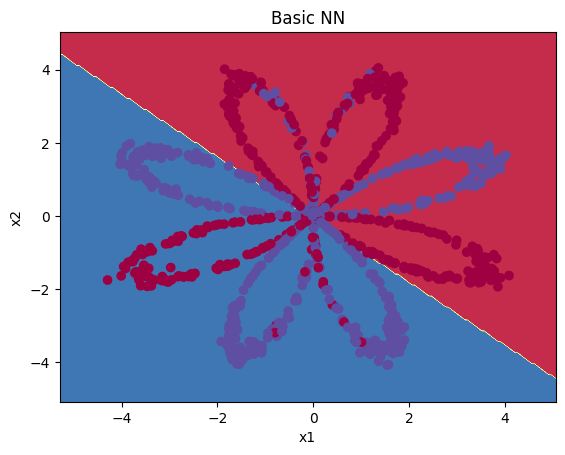

In [18]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

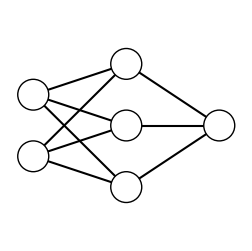

In [19]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [20]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

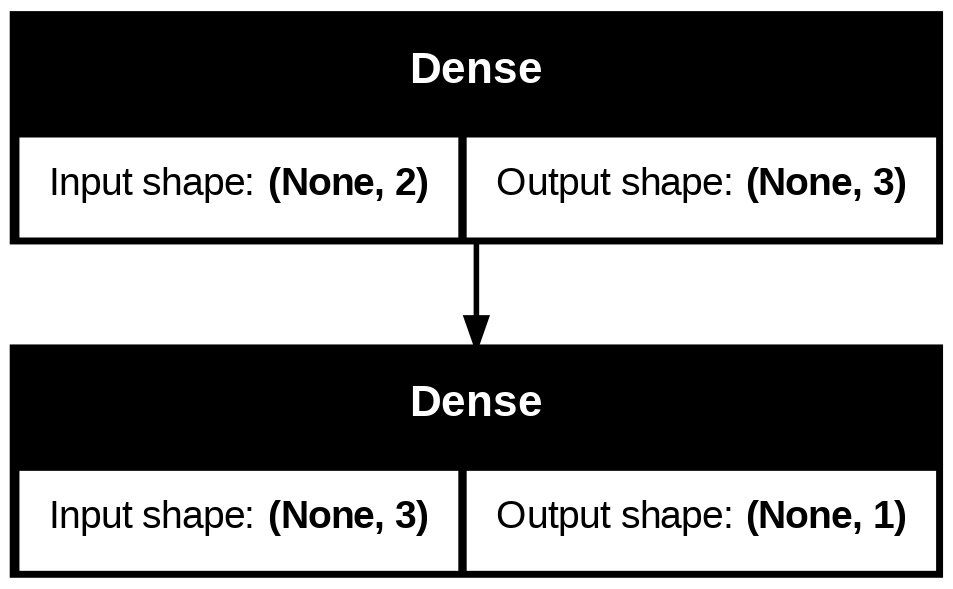

In [21]:
plot_model(model, show_shapes=True)

In [22]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5128 - loss: 0.9093 - val_accuracy: 0.4750 - val_loss: 0.8987
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 0.8290 - val_accuracy: 0.4750 - val_loss: 0.8254
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 0.7703 - val_accuracy: 0.4750 - val_loss: 0.7725
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 0.7293 - val_accuracy: 0.4750 - val_loss: 0.7357
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 0.7017 - val_accuracy: 0.4750 - val_loss: 0.7107
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5146 - loss: 0.6836 - val_accuracy: 0.5188 - val_loss: 0.6939
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5672 - loss: 0.6717 - val_accuracy: 0.6162 - val_loss: 0.6825
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6445 - loss: 0.6639 - val_accuracy: 0.

In [23]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.612930953502655
Test Accuracy: 0.621999979019165


1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step


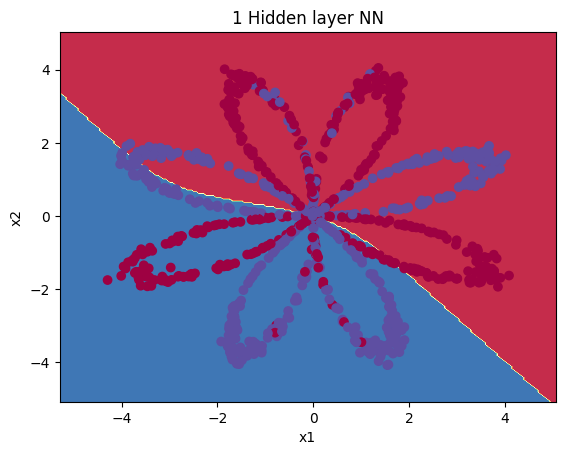

In [24]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [25]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
## se sustituye el activation model.add(layers.Dense(3, input_shape=(2,), activation=
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4604 - loss: 1.6064 - val_accuracy: 0.4563 - val_loss: 1.3938
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 1.2335 - val_accuracy: 0.4812 - val_loss: 1.0558
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5318 - loss: 0.9487 - val_accuracy: 0.5000 - val_loss: 0.8320
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5613 - loss: 0.7745 - val_accuracy: 0.6263 - val_loss: 0.7253
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6590 - loss: 0.6989 - val_accuracy: 0.6237 - val_loss: 0.6887
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.6756 - val_accuracy: 0.5063 - val_loss: 0.6786
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5038 - loss: 0.6703 - val_accuracy: 0.4563 - val_loss: 0.6759
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4670 - loss: 0.6694 - val_accuracy: 0.

Test Loss: 0.660162091255188
Test Accuracy: 0.48399999737739563
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


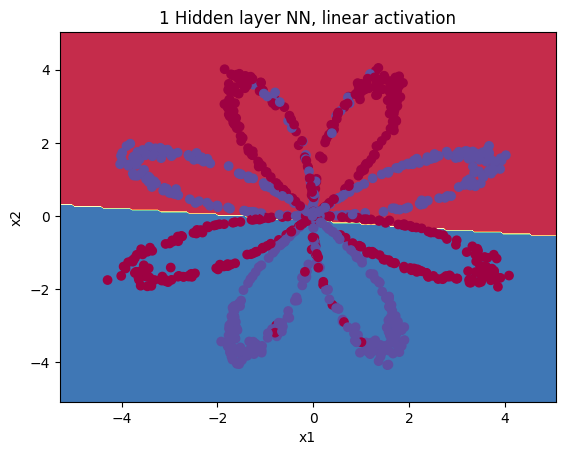

In [27]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## resutlados con linear

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

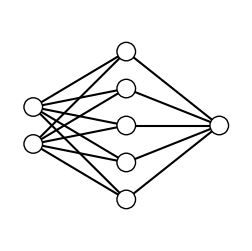

In [28]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [29]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
# la primera capa con 5 neuronas
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4840 - loss: 0.7442 - val_accuracy: 0.4212 - val_loss: 0.7387
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4639 - loss: 0.7049 - val_accuracy: 0.4700 - val_loss: 0.7087
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5245 - loss: 0.6859 - val_accuracy: 0.5325 - val_loss: 0.6925
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5709 - loss: 0.6753 - val_accuracy: 0.5900 - val_loss: 0.6820
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6156 - loss: 0.6675 - val_accuracy: 0.6100 - val_loss: 0.6739
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 0.6606 - val_accuracy: 0.6125 - val_loss: 0.6668
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6540 - val_accuracy: 0.6175 - val_loss: 0.6600
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6412 - loss: 0.6474 - val_accuracy: 0.

Test Loss: 0.5218234062194824
Test Accuracy: 0.8450000286102295
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


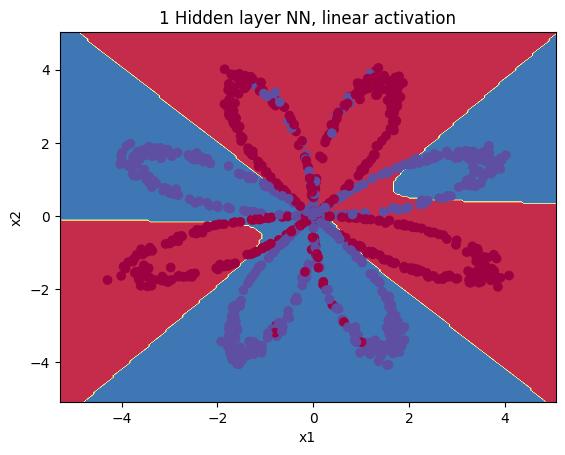

In [31]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

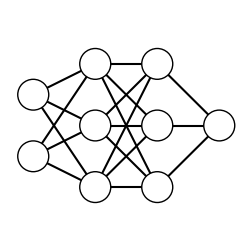

In [32]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [33]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
## escribimos el numero de neuronas 3
## model.add(layers.Dense(..., input_shape=(2,), activation='sigmoid'))
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))
# second hidden layer
## Complete the code
## agregando el mismo modelo de la linea anterior, solamente que ahora no es
##necesario el input?shape
## model.add(...
model.add(layers.Dense(3,  activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4872 - loss: 0.7160 - val_accuracy: 0.5250 - val_loss: 0.6977
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4922 - loss: 0.7002 - val_accuracy: 0.4187 - val_loss: 0.6956
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4613 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5118 - loss: 0.6923 - val_accuracy: 0.4712 - val_loss: 0.6935
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4871 - loss: 0.6904 - val_accuracy: 0.5038 - val_loss: 0.6920
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 0.6884 - val_accuracy: 0.5100 - val_loss: 0.6901
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5406 - loss: 0.6863 - val_accuracy: 0.5675 - val_loss: 0.6880
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5868 - loss: 0.6839 - val_accuracy: 0.

Test Loss: 0.6040418744087219
Test Accuracy: 0.6510000228881836
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step


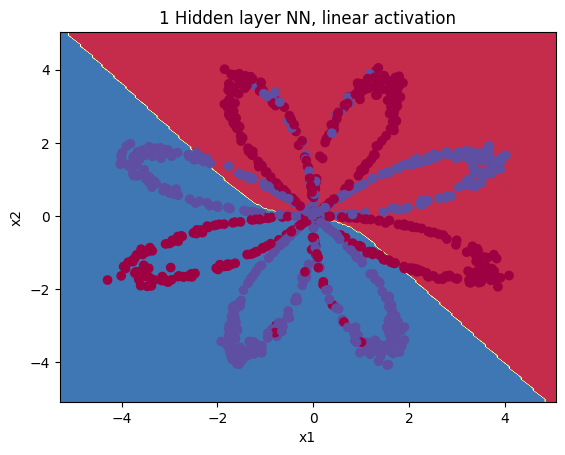

In [35]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [36]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3839 - loss: 0.7054 - val_accuracy: 0.6525 - val_loss: 0.6768
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6975 - loss: 0.6659 - val_accuracy: 0.6250 - val_loss: 0.6440
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6615 - loss: 0.6303 - val_accuracy: 0.6325 - val_loss: 0.6106
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6714 - loss: 0.5954 - val_accuracy: 0.6413 - val_loss: 0.5790
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6882 - loss: 0.5648 - val_accuracy: 0.6913 - val_loss: 0.5533
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7574 - loss: 0.5406 - val_accuracy: 0.7887 - val_loss: 0.5326
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8289 - loss: 0.5212 - val_accuracy: 0.8188 - val_loss: 0.5150
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.5047 - val_accuracy: 0.

Test Loss: 0.3601534962654114
Test Accuracy: 0.9039999842643738
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step


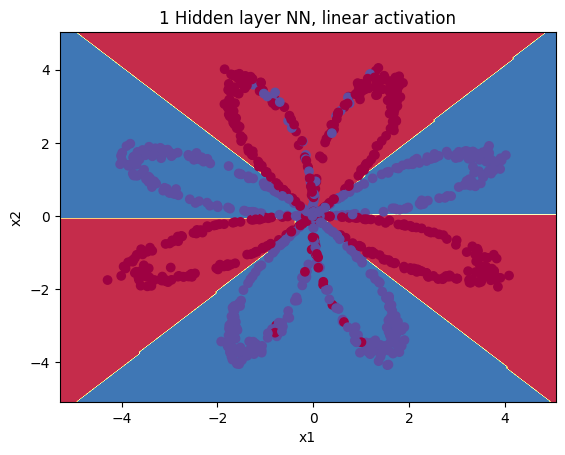

In [38]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [39]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

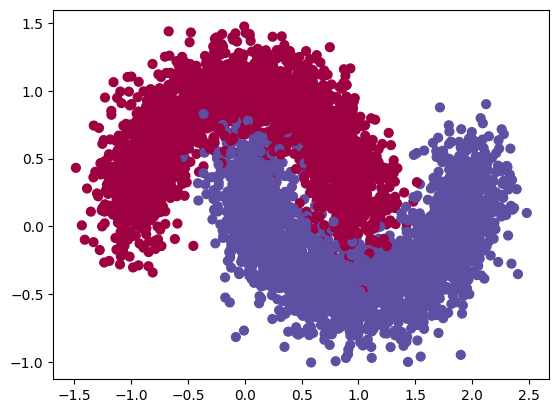

In [40]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [41]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [49]:
model = keras.Sequential()
## The first layer need to have the input_shape
## modelo de dos capas y 8 neuronas
model.add(layers.Dense(8, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(8,  activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [50]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3874 - loss: 0.7653 - val_accuracy: 0.8533 - val_loss: 0.6141
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.5833 - val_accuracy: 0.8200 - val_loss: 0.4899
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.4806 - val_accuracy: 0.8320 - val_loss: 0.4172
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8267 - loss: 0.4182 - val_accuracy: 0.8440 - val_loss: 0.3717
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.3770 - val_accuracy: 0.8520 - val_loss: 0.3411
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.3484 - val_accuracy: 0.8600 - val_loss: 0.3200
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8618 - loss: 0.3284 - val_accuracy: 0.8707 - val_loss: 0.3055
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8717 - loss: 0.3147 - val_accuracy: 0.8720 - val_loss:

Test Loss: 0.1862090677022934
Test Accuracy: 0.9240000247955322
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


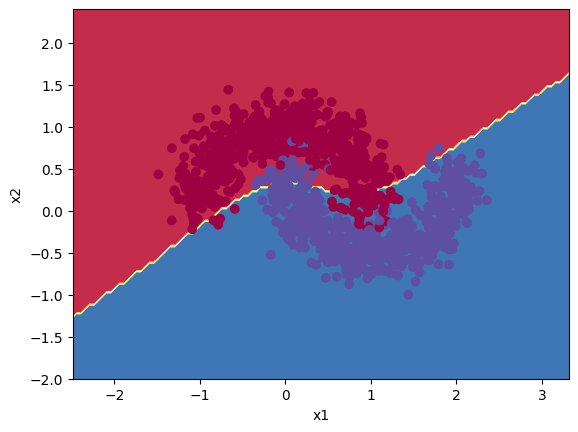

In [51]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Saving and Loading Keras Models

You can easily save your entire model (architecture, weights, and optimizer state) in a single call using either `.keras` or `.h5` formats.

- **`.keras`**: The default and recommended format from TensorFlow 2.12 onwards. It includes comprehensive model metadata and is future-proof.
- **`.h5`**: An older HDF5 format that is still widely used due to its simplicity and compatibility.


In [52]:
import datetime

# Save model with timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name_keras = f"keras_model_{current_time}.keras"
model_name_h5 = f"keras_model_{current_time}.h5"

# Save in .keras format (recommended for TensorFlow/Keras > 2.12)
model.save(model_name_keras)

# Alternatively, save in .h5 format
model.save(model_name_h5)

print(f"Models saved as: {model_name_keras} and {model_name_h5}")

Models saved as: keras_model_20251013-125026.keras and keras_model_20251013-125026.h5


In [53]:
# List files in current directory
!ls -l

total 100
-rw-r--r-- 1 root root 33128 Oct 13 12:50 keras_model_20251013-125026.h5
-rw-r--r-- 1 root root 26687 Oct 13 12:50 keras_model_20251013-125026.keras
-rw-r--r-- 1 root root 30749 Oct 13 12:25 model.png
drwxr-xr-x 1 root root  4096 Oct  9 13:36 sample_data


In [54]:
from tensorflow.keras.models import load_model

# Load your previously saved model
loaded_model = load_model(model_name_keras)  # or .h5

# Evaluate loaded model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded model accuracy: {accuracy*100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.1887
Loaded model accuracy: 92.40%


### Question 4: Train 10 epochs, save the model, load it, and then train 10 more epochs

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(9, input_shape=(2,), activation="tanh"))

## Second Layer, don't use input_shape
model...(...)

# output layer
model.add(layers.Dense(..., activation=...))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=..., validation_split=0.2, batch_size=64)

In [ ]:
# Save the model
model_name = ...
model.save(...

In [ ]:
# load the model



In [ ]:
# Train the model 10 more epochs
model.fit(X_train, y_train, epochs=..., validation_split=0.2, batch_size=64)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(...)(inputs)
...

## output layer
outputs = layers.Dense(...


model = keras.Model(inputs=inputs,...

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Visualize decision boundary by epoch

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [ ]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X, y = generate_spiral_dataset(n_points)

In [ ]:
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [ ]:
# Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 60
epoch_images = []

for epoch in range(n_epochs):
    model.fit(X_train, y_train, epochs=1, verbose=0)
    epoch_image = f'epoch_{epoch}.png'
    epoch_images.append(epoch_image)

    plot_save_decision_boundary(model, X_test, y_test, epoch, epoch_image)

In [ ]:
from PIL import Image as Image_PIL

# Create the GIF
gif_filename = 'epoch_animation.gif'
images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images]

duration = 0.15
images[0].save(gif_filename,
            format='GIF',
            append_images=images[1:],
            save_all=True,
            duration=duration*1000,
            loop=0)

# Delete the individual epoch images
for epoch_image in epoch_images:
    os.remove(epoch_image)

In [ ]:
# Display the GIF
Image(filename=gif_filename)